<a href="https://colab.research.google.com/github/XXMarcosSSantos/analise_viagens_2023/blob/main/Anal%C3%ADse0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Analise portal da transparencia


In [5]:

caminho_dados = "/content/drive/MyDrive/AD/2023_Viagem.csv"
caminho_saida_tabela = "/content/drive/MyDrive/AD/output/tabela_2023.xlsx"
caminho_saida_grafico = "/content/drive/MyDrive/AD/output/grafico_2023.png"

In [6]:
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format','{:.2f}'.format)

#lendo os dados
df_viagens = pd.read_csv(caminho_dados, encoding="Windows-1252", sep=";" , decimal=",")

#criando nova coluna de despesas
df_viagens['despesas'] = df_viagens['Valor diárias'] + df_viagens['Valor passagens'] + df_viagens['Valor outros gastos']

#ajustando valores nulos de cargo
df_viagens['Cargo'] = df_viagens['Cargo'].fillna('NÃO IDENTIFICADO')

#Convertendo culunas de data
df_viagens['Período - Data de início'] = pd.to_datetime(df_viagens['Período - Data de início'],format="%d/%m/%Y")
df_viagens['Período - Data de fim'] = pd.to_datetime(df_viagens['Período - Data de fim'],format="%d/%m/%Y")

#criando novas colunas de datas
df_viagens['Mês da viagem'] = df_viagens['Período - Data de início'].dt.month_name()
df_viagens['dias de viagem']=(df_viagens['Período - Data de fim'] - df_viagens['Período - Data de início']).dt.days

In [7]:
#Criando tabela consolidada
df_viagens_consolidado = (df_viagens
    .groupby('Cargo')
    .agg(
        despesa_media=('despesas', 'mean'),
        duracao_media=('dias de viagem', 'mean'),
        despesas_totais=('despesas', 'sum'),
        destino_mais_frequente=("Destinos", pd.Series.mode),
        n_viagens=("Nome", 'count')
    )
    .reset_index()
    .sort_values(by='despesas_totais', ascending=False))

# Filtrando tabela consolidada com cargo relevante (> 1% das viagens)
df_cargo = df_viagens['Cargo'].value_counts(normalize=True).reset_index()
cargos_relevante = df_cargo.loc[df_cargo['proportion']> 0.01, 'Cargo']  # Ajustando os nomes das colunas
filtro = df_viagens_consolidado['Cargo'].isin(cargos_relevante)

# Aplicando o filtro e gerando a tabela final
df_final = df_viagens_consolidado[filtro].sort_values(by='n_viagens', ascending=False)

#salvando a tabela final
df_final.to_excel(caminho_saida_tabela, index=False)

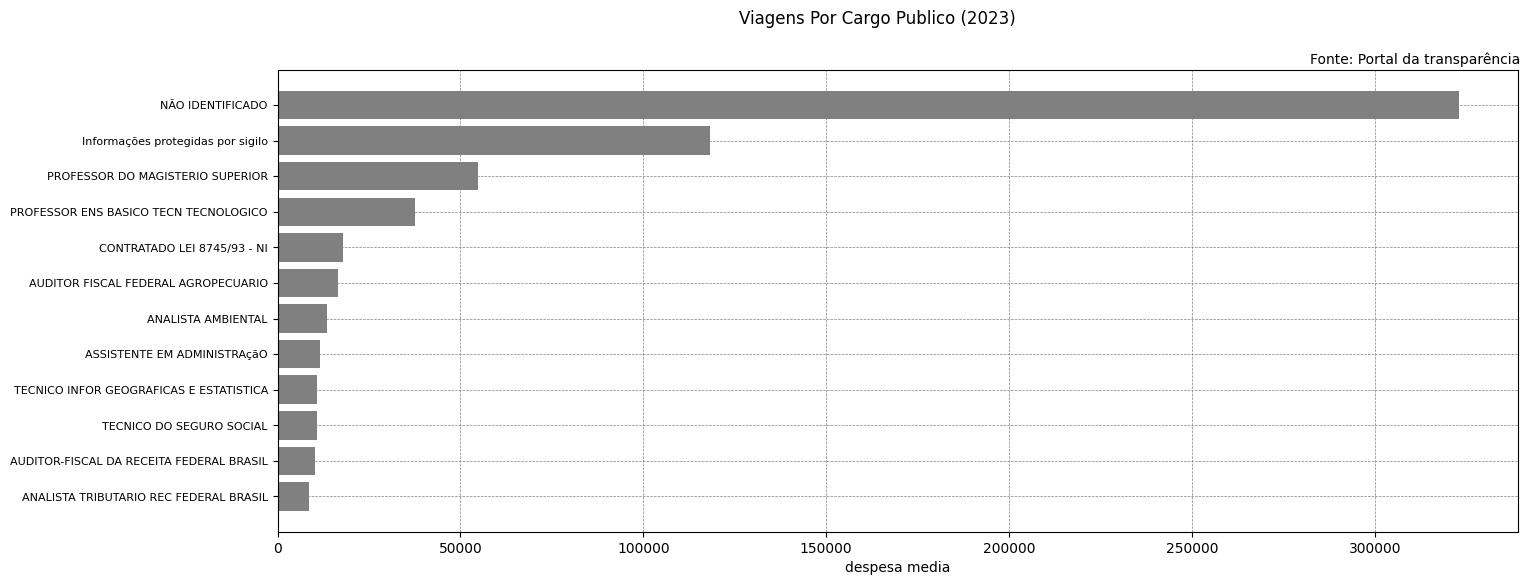

In [9]:
import matplotlib.pyplot as plt

#criando a figura
fig, ax = plt.subplots(figsize=(16,6))

#plotando grafico
ax.barh(df_final['Cargo'],df_final['n_viagens'],color='#808080')
ax.invert_yaxis()

#ajustando o grafico
fig.suptitle('Viagens Por Cargo Publico (2023)')
plt.figtext(0.77, 0.89, "Fonte: Portal da transparência")
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.yticks(fontsize=8)
plt.xlabel('despesa media')

#salvando o grafico
plt.savefig(caminho_saida_grafico, bbox_inches='tight')